### Calcualte the detuning coefficients for a given amplitude detuning
- PyHEADTAIL v1.13.5 (Python3).
- The tune is calculated using **NAFF** (NAFFlib).
- Tracking 900 particles for 1000 turns is enough to determine the tune.
- The initial distribution is a grid in x-y up to 6 σx,y.
- The tune spread is linear. Therefore is the difference of the tune of the particle with the maximum action from the one with the minimum.

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import NAFFlib as pnf

# Added by Themis
import scipy

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D
from math import *

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

PyHEADTAIL v1.13.5


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


### Plotting parameters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [3]:
plt.close('all')

### Define the conditions of the study

In [4]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(1e3)            #number of cycles to run the simulation for
decTurns = int(1)               #how often to record data

Q_x = 26.13                 #How many times the particles oscillate in phase space each turn 

Q_y = 26.18                           # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

filename = './input/file.txt'      #Where the data for the run is saved

In [29]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma          = 287.8
p0             = m_p*c*np.sqrt(gamma**2 - 1)
beta           = np.sqrt(1 - 1/gamma**2)
circumference  = 6911.5623
frev           = 299792458/circumference

# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments     = 1
s              = np.arange(0, n_segments + 1) * circumference / n_segments
alpha_x        = -0.8757651182 * np.ones(n_segments) 
beta_x         = 29.23897404 * np.ones(n_segments) 
D_x            = 0 * np.ones(n_segments)
alpha_y        = 1.898525134 * np.ones(n_segments) 
beta_y         = 76.07315729 * np.ones(n_segments)
D_y            = 0 * np.ones(n_segments)

Qp_x           = 0 #10
Qp_y           = 0

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha           = 1.9e-3
Q_s             = 0.0035
h1, h2          = 4620, 9240
V1, V2          = 4.5e6, 0e6
dphi1, dphi2    = 0, np.pi
p_increment     = 0 * e/c * circumference/(beta*c)


# CREATE BEAM
# ===========
macroparticlenumber = 900

charge    = e
mass      = m_p
intensity = 1.5e11

R         = circumference/(2*np.pi)
eta       = alpha-1/gamma**2
beta_z    = np.abs(eta)*R/Q_s

epsn_x    = 2e-6
epsn_y    = 2e-6

sigma_z   = 0.155 #2*0.0755

sigma_x   = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp  = sigma_x/beta_x[0]
sigma_y   = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp  = sigma_y/beta_y[0]
sigma_dp  = sigma_z/beta_z
epsn_z    = 4*np.pi * p0/e * sigma_z*sigma_dp


# Create bunch just to create the object. The redifine all the coordinates
bunch     = generate_Gaussian6DTwiss(
    macroparticlenumber, intensity, charge, mass, circumference, gamma,
    alpha_x, alpha_y, beta_x, beta_y, beta_z, epsn_x, epsn_y, epsn_z)

#### Create the initial conditions in σ (up to 3 σ)

For the horizontal beam size $\sigma_x$:

\begin{equation}
\sigma_x = \sqrt{\epsilon_{x_{geom}}  \beta_x(s)}
\end{equation}

, where $\beta_x(s)$ the beta function at the location s of the lattice. Here we study at the location of the CC in SPS (are the values that are used here for the one turn map).

\begin{equation}
\epsilon_{x_{norm}} = \epsilon_{x_{geom}}  \beta_0 \gamma_0
\end{equation}

, where $ \beta_0 \gamma_0 $ the relativistic parameters of the reference particle.

The same appleis for the vertical plane y.

In [26]:
# Compute the geometric emittances
ex_geom = epsn_x/(beta*gamma)  
ey_geom = epsn_y/(beta*gamma)  
print(ex_geom, ey_geom)

6.9493122765769245e-09 1.3898624553153849e-08


In [27]:
# Compute the sigmas
sigma_x = np.sqrt(ex_geom*beta_x[0])
sigma_y = np.sqrt(ey_geom*beta_y[0])
print(sigma_x, sigma_y)

0.000450766859086475 0.0010003504225155689


#### Create the initial condition

As the detuning from octupoles is linear with action we need to create a distribution which is linearly and evenly spaced in action.  

\begin{equation}
x = \sqrt{2 \beta_x(s) J_x}
\end{equation}

or

\begin{equation}
J_x = \frac{x^2 }{\beta_x(s)}
\end{equation}
, where $\beta_x(s)$ the beta function at the location s of the lattice.

Same applies for the vertical plane.

In [28]:
steps = int(np.sqrt(macroparticlenumber))

# Define the upper limit of the distibution
xmax, ymax = 3*sigma_x, 3*sigma_y

# Change to action phase variables just to create the linspace
Jxmin, Jymin = 10**(-13), 10**(-13) # for zero you cannot calculate the tune
Jxmax, Jymax = xmax**2/(beta_x[0]), ymax**2/(beta_y[0])

print('Jx min = {}, Jx max={}'.format(Jxmin, Jxmax))
print('Jy min = {}, Jy max={}'.format(Jymin, Jymax))

Jx = np.linspace(10**(-13), Jxmax, steps)
Jy = np.linspace(10**(-13), Jymax, steps)

# Return to x-y
x = np.sqrt(Jx*2*beta_x[0])
y = np.sqrt(Jy*2*beta_y[0])

# meshgrid
xx, yy = np.meshgrid(x, y)

bunch.x = xx.flatten()
bunch.y = yy.flatten()

#bunch.x =  0 * np.ones(macroparticlenumber)
bunch.xp = 0 * np.ones(macroparticlenumber)
bunch.yp = 0 * np.ones(macroparticlenumber)
bunch.z = 0 * np.ones(macroparticlenumber)
bunch.dp = 0 * np.ones(macroparticlenumber)


afile = open('./input/bunch', 'wb')
pickle.dump(bunch, afile)
afile.close()

Jx min = 1e-13, Jx max=3.1271905244596165e-08
Jy min = 1e-13, Jy max=6.9493122765769245e-09


#### Keep the index of the maximum and minimum action 
The detuning should be linear with action. Therefore the tune spread will be computed as the difference in the tune of the particle with maximum and minimum actions.

In [9]:
y_norm = bunch.y/sqrt(beta_y) # the index 0 corresponds to turn
py_norm = bunch.yp*sqrt(beta_x) + bunch.y*alpha_x/sqrt(beta_x)
Jy2_list_initial = (y_norm**2 + py_norm**2) # actually this quantity is 2*Jy

J_max = np.amax(Jy2_list_initial)
J_min = np.amin(Jy2_list_initial)
# Find the indeces of the maximum and minimum action
index_Jmax = np.where(Jy2_list_initial == np.amax(J_max))[0][0]
index_Jmin = np.where(Jy2_list_initial == np.amin(J_min))[0][0]
print('indedx 2Jmax = {}, index 2Jmin = {}'.format(index_Jmax, index_Jmin))

indedx 2Jmax = 870, index 2Jmin = 0


### Plot the initial distribution

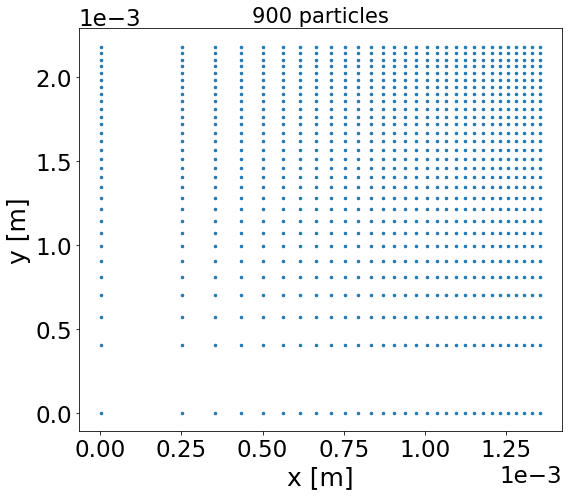

In [10]:
plt.plot(bunch.x, bunch.y, '.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('{} particles'.format(macroparticlenumber))
plt.ticklabel_format(axis="x", style="sci",  scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci",  scilimits=(0,0))
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('initial_distribution_pyheadtail_6sigma_xy.png')

### Define the detuning coefficients

- The detuning coefficients here are obtained from PTC in the direcotry /madx/.
- However to be used here they need to be multiplied with the reference moemntum due to the definition of the detuner module in PyHEADTAIL source code (/trackers/detunes.py).

\begin{equation}
dQ_x = \frac{\alpha_{xx} J_x + \alpha_{xy}J_y}{p_0}
\end{equation}

\begin{equation}
dQ_y = \frac{\alpha_{yy} J_y + \alpha_{yx}J_x}{p_0}
\end{equation}

, where $p_0$ the reference momentum.

- The factor 2 is a result of the definition of the actions $J_x$ and $J_y$.

In [11]:
bunch.p0

1.4431339903887914e-16

In [12]:
scale_factor = 2*bunch.p0 
# ATTENTION when using this scaling factor for PyHEADTAIL. The factor 2 maybe is not required. 

In [13]:
app_x = 179.3585107*scale_factor 
app_xy = 0.0 #-441.3397664*scale_factor 
# define the lis of app_y values you are gonna scan. defined directly in pyheadtail units
a = np.linspace(-1e-17, -1e-11, 20)
b = np.linspace(-1e-12, 0, 10)
c = np.concatenate((a,b), axis=0)
app_y_list = np.sort(c)[::-1]

### Create loop over the app_y_values

In [14]:
DQy_list = []
for app_y in app_y_list:
    ### CREATE THE TRANSVERSE MAP
    transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x, app_y, app_xy)]) 


    ### CREATE THE LONGITUDINAL MAP
    longitudinal_map = LinearMap([alpha], circumference, Q_s)
    
    ### Set up the accelerator map and start tracking
    t0 = time.clock()

    #reload object from file, use the same distribution for all studies
    file2 = open('./input/bunch', 'rb')
    bunch = pickle.load(file2)
    file2.close()

    print('--> Begin tracking...')
    one_turn_map = [transverse_map[0]] + [longitudinal_map]
    n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                           # We want this number as an integer, so it can be used in the next functions. 
    X = []
    Y = []
    XP = []
    YP = []
    sigma = []
    delta = []

    for i in range(n_turns):
       #These next two lines actually "run" the simulation - the computationally heavy part
        for m in one_turn_map:
            m.track(bunch)

        X.append(bunch.x)
        Y.append(bunch.y)
        XP.append(bunch.xp)
        YP.append(bunch.yp)
        sigma.append(bunch.z)
        delta.append(bunch.dp)

        
    dataExport = [X, Y, XP, YP, sigma, delta]
    f = open(filename, 'w')

    
    
    with f:
        out = csv.writer(f, delimiter=',')
        out.writerows(zip(*dataExport))

    print('--> Done.')

    print("Simulation time in seconds: " + str(time.clock() - t0))

    
    ### organise the tbt data. Group them in a list for each particle
    y_data = {}
    py_data = {}
    for particle in range(macroparticlenumber):
        y_data[particle] = []
        py_data[particle] = []
    # maybe even 100 turns are enough
    for particle in range(macroparticlenumber):
        for turn in range(n_turns):
            y_data[particle].append(Y[turn][particle])
            py_data[particle].append(YP[turn][particle])
    # Compute the tunes
    y_lost_particles = []
    Qy_list = []

    for particle in range(macroparticlenumber):
        if np.isnan(y_data[particle]).any() or np.isnan(py_data[particle]).any():
            y_lost_particles.append(particle)
            print('particle {} lost'.format(particle))
        else:        
            signal_y = y_data[particle]
            Qy_list.append(pnf.get_tune(np.array(signal_y)))
            
    # Compute the tune spread in the plane of interest
    DQy = Qy_list[index_Jmax] - Qy_list[index_Jmin]
    DQy_list.append(DQy)
    print('for ayy={}, DQy={}'.format(app_y, DQy))


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


--> Begin tracking...
--> Done.
Simulation time in seconds: 35.735174


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


for ayy=0.0, DQy=-4.163336342344337e-16
--> Begin tracking...
--> Done.
Simulation time in seconds: 39.80026300000001
for ayy=-1e-17, DQy=-2.1669278316149843e-09
--> Begin tracking...
--> Done.
Simulation time in seconds: 41.559239000000005
for ayy=-1.111111111111111e-13, DQy=-2.4076061857586373e-05
--> Begin tracking...
--> Done.
Simulation time in seconds: 37.75732600000002
for ayy=-2.222222222222222e-13, DQy=-4.81550989135382e-05
--> Begin tracking...
--> Done.
Simulation time in seconds: 39.03810800000002
for ayy=-3.333333333333333e-13, DQy=-7.223090080632488e-05
--> Begin tracking...
--> Done.
Simulation time in seconds: 37.85914199999999
for ayy=-4.444444444444444e-13, DQy=-9.631091209433285e-05
--> Begin tracking...
--> Done.
Simulation time in seconds: 38.91441200000003
for ayy=-5.263252631578948e-13, DQy=-0.00011405110908124794
--> Begin tracking...
--> Done.
Simulation time in seconds: 38.71072800000002
for ayy=-5.555555555555556e-13, DQy=-0.00012038511443232536
--> Begin tra

###  Save the tune spread for each value of ayy in a pickle

In [15]:
my_tunes = {'ayy (1/m)':app_y_list/scale_factor, 'DQy':DQy_list}
pickle.dump(my_tunes, open('./output/DQy_vs_ayy_xy_final.pkl', 'wb'))

#### Print the minimum and maximum action at the last turn

In [167]:
y_norm = Y[-1]/sqrt(beta_y) # the index 0 corresponds to turn
py_norm = YP[-1]*sqrt(beta_x) + Y[-1]*alpha_x/sqrt(beta_x)
Jy2_list_final = (y_norm**2 + py_norm**2) # actually this quantity is 2*Jy
print('At the last turn Jymin = {}, Jymax = {}'.format(Jy2_list_final[index_Jmin], Jy2_list_final[index_Jmax]))

At the last turn Jymin = 1.9999999999997729e-13, Jymax = 6.25438104891926e-08


The final action is slightly different than the initial one. Is this difference acceptable?